In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import jax
import numpy as np
import matplotlib.pyplot as plt
from confirm.lewislib import lewis
import confirm.imprint as ip

In [2]:
name = "1d_slice"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}

In [3]:
bad_arm = -1.0
control = np.linspace(-1.0, 1.0, 2000)
theta = np.stack((control, control, control, np.full_like(control, bad_arm)), axis=1)
radii = theta.copy()
radii[:, :3] = (control[1] - control[0]) * 0.5
radii[:, -1] = 0
g_raw = ip.init_grid(theta, radii)
g_raw.df["null_truth0"] = True
g_raw.df["null_truth1"] = True
g_raw.df["null_truth2"] = True
g = g_raw
# .add_null_hypos([
#     ip.hypo('theta0 > theta1'), ip.hypo('theta0 > theta2'), ip.hypo('theta0 > theta3')
# ])
# g = g_raw.subset(g_raw.df['null_truth0'] & g_raw.df['null_truth1'] & g_raw.df['null_truth2'])

In [4]:
# rej_df = ip.validate(
#     lewis.Lewis45Model,
#     g,
#     lam=0.06253,
#     K=2**12,
#     tile_batch_size=256,
#     model_kwargs=params,
# )
# plt.plot(g.df['theta0'], rej_df['tie_est'], '.')
# plt.show()

In [3]:
import os
import time
import modal
import pandas as pd
import confirm.cloud.modal_util as modal_util

stub = modal.Stub("confirm")

img = modal_util.get_image()


@stub.function(
    image=img,
    gpu=modal.gpu.A100(),
    retries=0,
    mounts=modal.create_package_mounts(["confirm"]),
    timeout=60 * 30,
)
def cloud_validate(g, *, K, params):
    start = time.time()
    rej_df = ip.validate(
        lewis.Lewis45Model,
        g,
        lam=0.06253,
        K=K,
        tile_batch_size=256,
        model_kwargs=params,
    )
    print(time.time() - start)
    return rej_df


def parallel_validate(g, *, n_workers, K, params):
    gs = [ip.grid.Grid(d, g.null_hypos) for d in np.array_split(g.df, n_workers)]
    with stub.run():
        rej_dfs = list(
            cloud_validate.map(
                gs, kwargs={"K": K, "params": params}, order_outputs=True
            )
        )
    return pd.concat(rej_dfs)

## [-1, 1] with $\theta_4 = -1$

In [7]:
# rej_df = parallel_validate(g, n_workers=2, K=2**20, params=params)
with stub.run():
    rej_df = cloud_validate(g, K=2**20, params=params)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-WANAmtn5M6WEgwUAwTuJlW

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

779.5158467292786


✓ App completed.

In [8]:
rej_df.to_parquet("./1d_slice/1d_slice.parquet")

In [4]:
import pandas as pd

rej_df = pd.read_parquet("./1d_slice/1d_slice.parquet")

In [5]:
max_tile = g.df.loc[rej_df["tie_bound"].idxmax()]

In [6]:
max_tile

id             10251312003193767380
active                         True
eligible                       True
parent_id                         0
theta0                     0.492746
theta1                     0.492746
theta2                     0.492746
theta3                         -1.0
radii0                       0.0005
radii1                       0.0005
radii2                       0.0005
radii3                          0.0
null_truth0                    True
null_truth1                    True
null_truth2                    True
Name: 1492, dtype: object

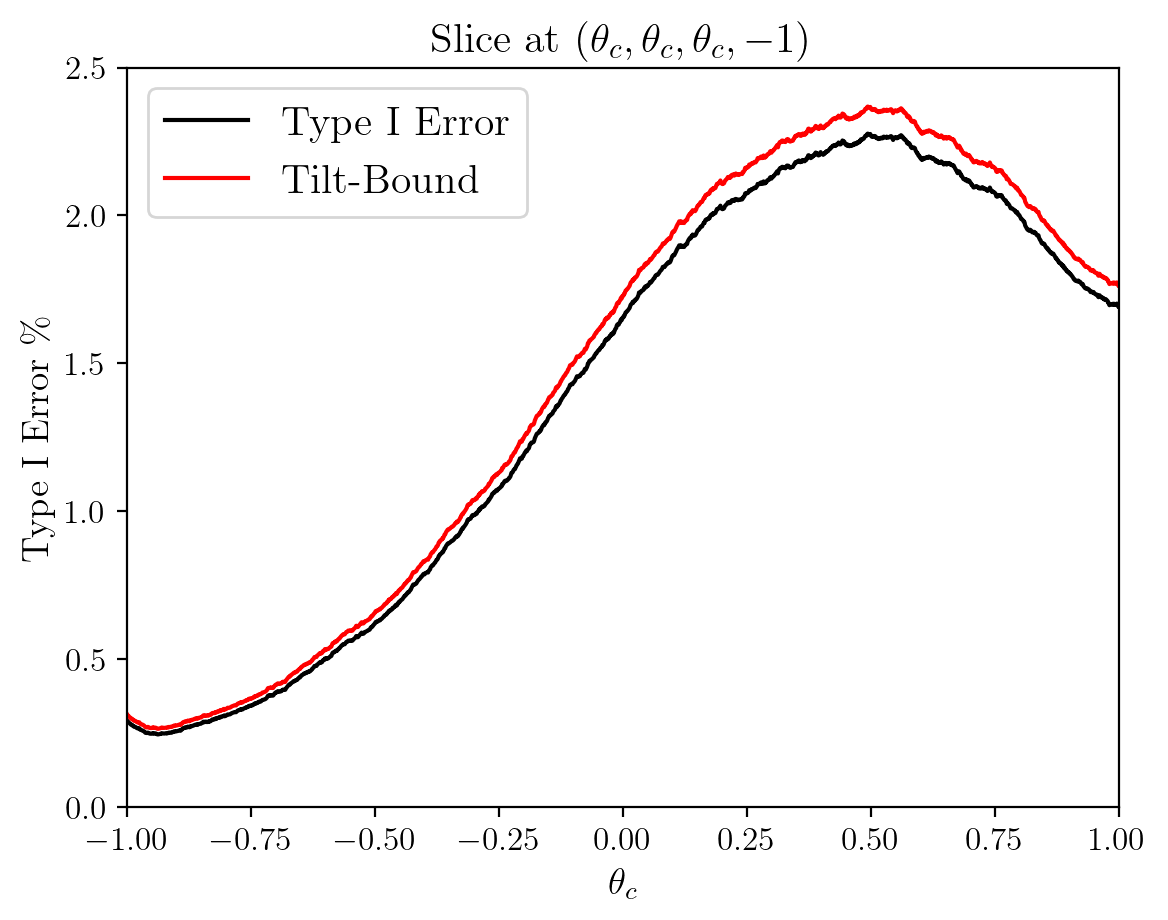

In [8]:
plt.plot(g.df["theta0"], 100 * rej_df["tie_est"], "k-", label="Type I Error")
# plt.plot(g.df["theta0"], 100 * rej_df["tie_cp_bound"], "b-", label="Clopper-Pearson")
plt.plot(g.df["theta0"], 100 * rej_df["tie_bound"], "r-", label="Tilt-Bound")
plt.xlim([-1, 1])
plt.ylim([0, 2.5])
plt.xlabel("$\\theta_{c}$")
plt.ylabel("Type I Error \%")
plt.legend()
plt.title("Slice at $(\\theta_{c}, \\theta_{c}, \\theta_{c}, -1)$")
plt.savefig("lewis_1d_slice.pdf", bbox_inches="tight")
plt.show()

## Orthogonal slice

In [18]:
g = ip.cartesian_grid([-1, -10], [1, -1], n=[10, 200])
g.df["theta3"] = g.df["theta1"]
g.df["theta1"] = g.df["theta0"]
g.df["theta2"] = g.df["theta0"]
g.df["radii3"] = g.df["radii1"]
g.df["radii0"] = 0
g.df["radii1"] = 0
g.df["radii2"] = 0
g.df["null_truth0"] = True
g.df["null_truth1"] = True
g.df["null_truth2"] = True

In [19]:
g.df["theta0"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
195    0.0
196    0.0
197    0.0
198    0.0
199    0.0
Name: theta0, Length: 200, dtype: float64

In [10]:
# bad_arm = np.linspace(-5.0, -1.0, 2000)
# control = np.full_like(bad_arm, 0.492746)
# theta = np.stack(
#     (control, control, control, np.full_like(control, bad_arm)), axis=1
# )
# radii = theta.copy()
# radii[:,:3] = 0.0
# radii[:,-1] = (bad_arm[1] - bad_arm[0]) * 0.5
# # radii[:,-1] = 0
# g_raw = ip.init_grid(theta, radii)
# g_raw.df['null_truth0'] = True
# g_raw.df['null_truth1'] = True
# g_raw.df['null_truth2'] = True
# g = g_raw

In [7]:
with stub.run():
    rej_df = cloud_validate(g, K=2**20, params=params)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-kecORCBSHrqnmhqOf7tYgP

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

Runner failed with exception: Runner disappeared, in-progress inputs will be re-scheduled


Runner failed with exception: Worker disappeared, in-progress inputs will be re-scheduled


Runner failed with exception: Runner disappeared, in-progress inputs will be re-scheduled


Runner failed with exception: Worker disappeared, in-progress inputs will be re-scheduled


Runner failed with exception: Runner disappeared, in-progress inputs will be re-scheduled


780.1337018013


✓ App completed.

In [8]:
rej_df.to_parquet("./1d_slice/1d_orthogonal_wider.parquet")

In [11]:
import pandas as pd

rej_df = pd.read_parquet("./1d_slice/1d_orthogonal_wider.parquet")

In [12]:
rej_df

,tie_sum,tie_est,tie_cp_bound,tie_bound
0,31924,0.030445,0.030838,0.031586
1,32262,0.030767,0.031162,0.031916
2,31988,0.030506,0.030899,0.031649
3,31178,0.029734,0.030122,0.030857
4,30423,0.029014,0.029397,0.030118
...,...,...,...,...
1995,19968,0.019043,0.019356,0.032460
1996,22678,0.021627,0.021960,0.036505
1997,23947,0.022838,0.023179,0.038385
1998,22252,0.021221,0.021551,0.035872


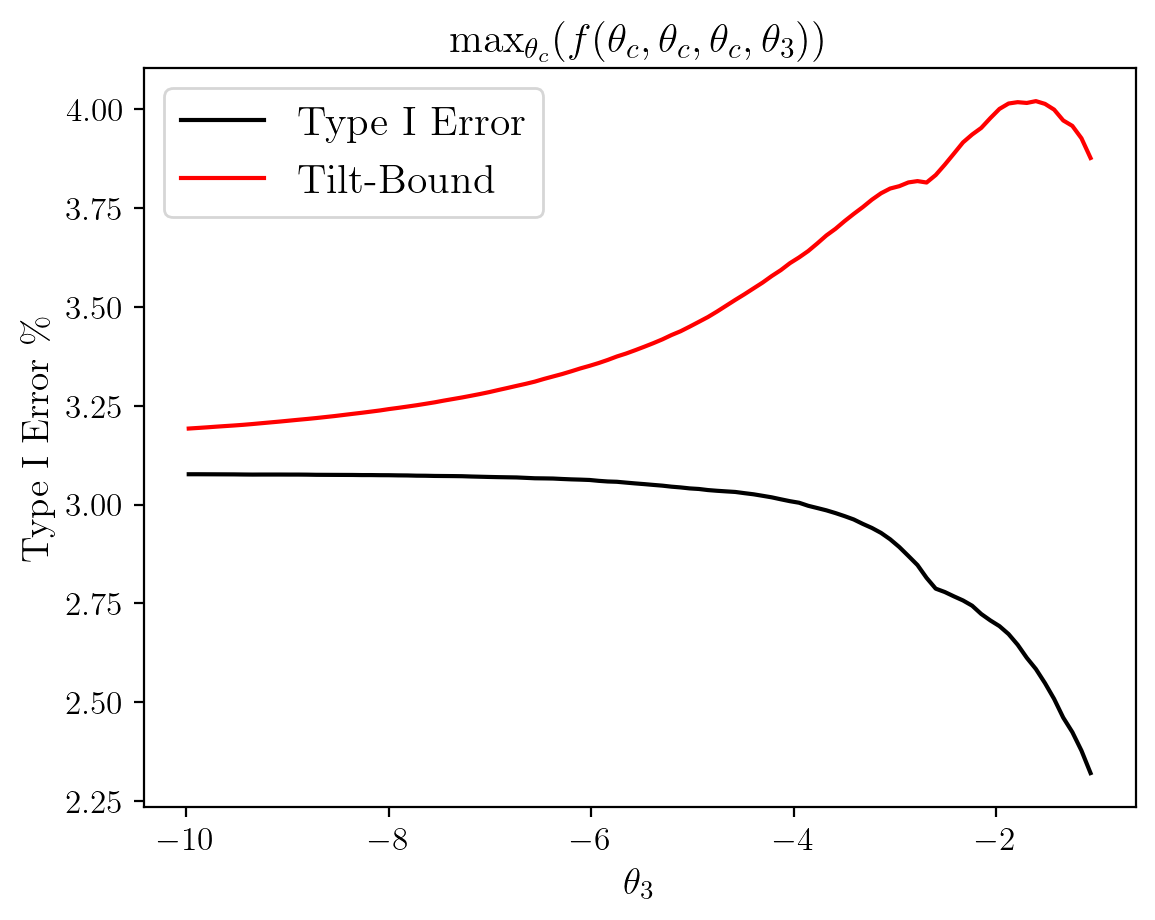

In [17]:
worst_tie = rej_df["tie_est"].values.reshape((100, 20)).max(axis=1)
worst_bound = rej_df["tie_bound"].values.reshape((100, 20)).max(axis=1)
plt.plot(
    g.df["theta3"].values.reshape((100, 20))[:, 0],
    100 * worst_tie,
    "k-",
    label="Type I Error",
)
plt.plot(
    g.df["theta3"].values.reshape((100, 20))[:, 0],
    100 * worst_bound,
    "r-",
    label="Tilt-Bound",
)
plt.legend()
plt.xlabel(r"$\theta_{3}$")
plt.ylabel(r"Type I Error \%")
plt.title(r"$\max_{\theta_c}(f(\theta_c, \theta_c, \theta_c, \theta_3))$")
plt.savefig("lewis_1d_orthogonal.pdf", bbox_inches="tight")
plt.show()

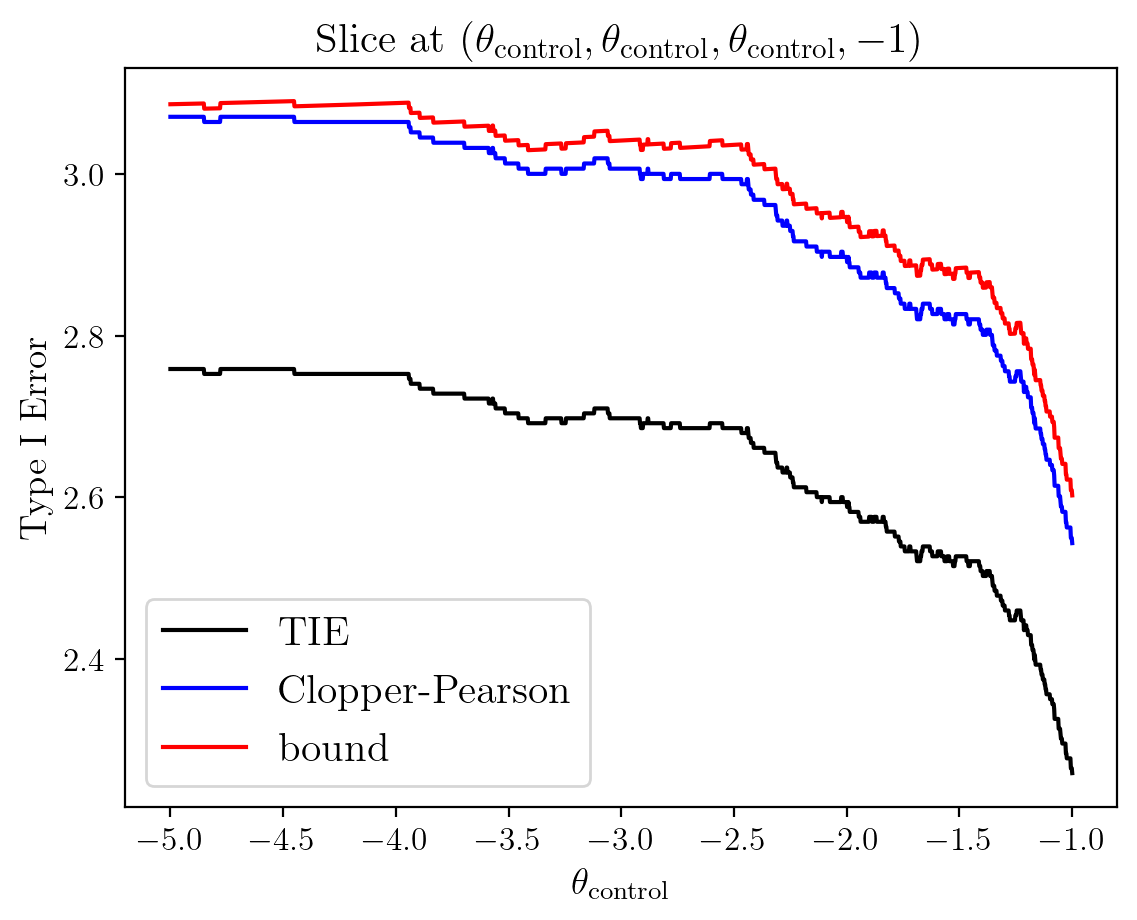

In [25]:
plt.plot(g.df["theta3"], 100 * rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta3"], 100 * rej_df["tie_cp_bound"], "b-", label="Clopper-Pearson")
plt.plot(g.df["theta3"], 100 * rej_df["tie_bound"], "r-", label="bound")
# plt.xlim([-1, 1])
# plt.ylim([0, 2.5])
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.savefig("lewis_1d_orthogonal.pdf", bbox_inches="tight")
plt.show()

## Double figure

In [77]:
bad_arm = -1.0
control = np.linspace(-1.0, 1.0, 2000)
theta = np.stack((control, control, control, np.full_like(control, bad_arm)), axis=1)
radii = theta.copy()
radii[:, :3] = (control[1] - control[0]) * 0.5
radii[:, -1] = 0
g_raw = ip.init_grid(theta, radii)
g_raw.df["null_truth0"] = True
g_raw.df["null_truth1"] = True
g_raw.df["null_truth2"] = True
g1d = g_raw
rej_df1d = pd.read_parquet("./1d_slice/1d_slice.parquet")

g = ip.cartesian_grid([-1, -5], [1, -1], n=[20, 100])
g.df["theta3"] = g.df["theta1"]
g.df["theta1"] = g.df["theta0"]
g.df["theta2"] = g.df["theta0"]
g.df["radii3"] = g.df["radii1"]
g.df["radii0"] = 0
g.df["radii1"] = 0
g.df["radii2"] = 0
g.df["null_truth0"] = True
g.df["null_truth1"] = True
g.df["null_truth2"] = True
gortho = g
rej_dfortho = pd.read_parquet("./1d_slice/1d_orthogonal.parquet")

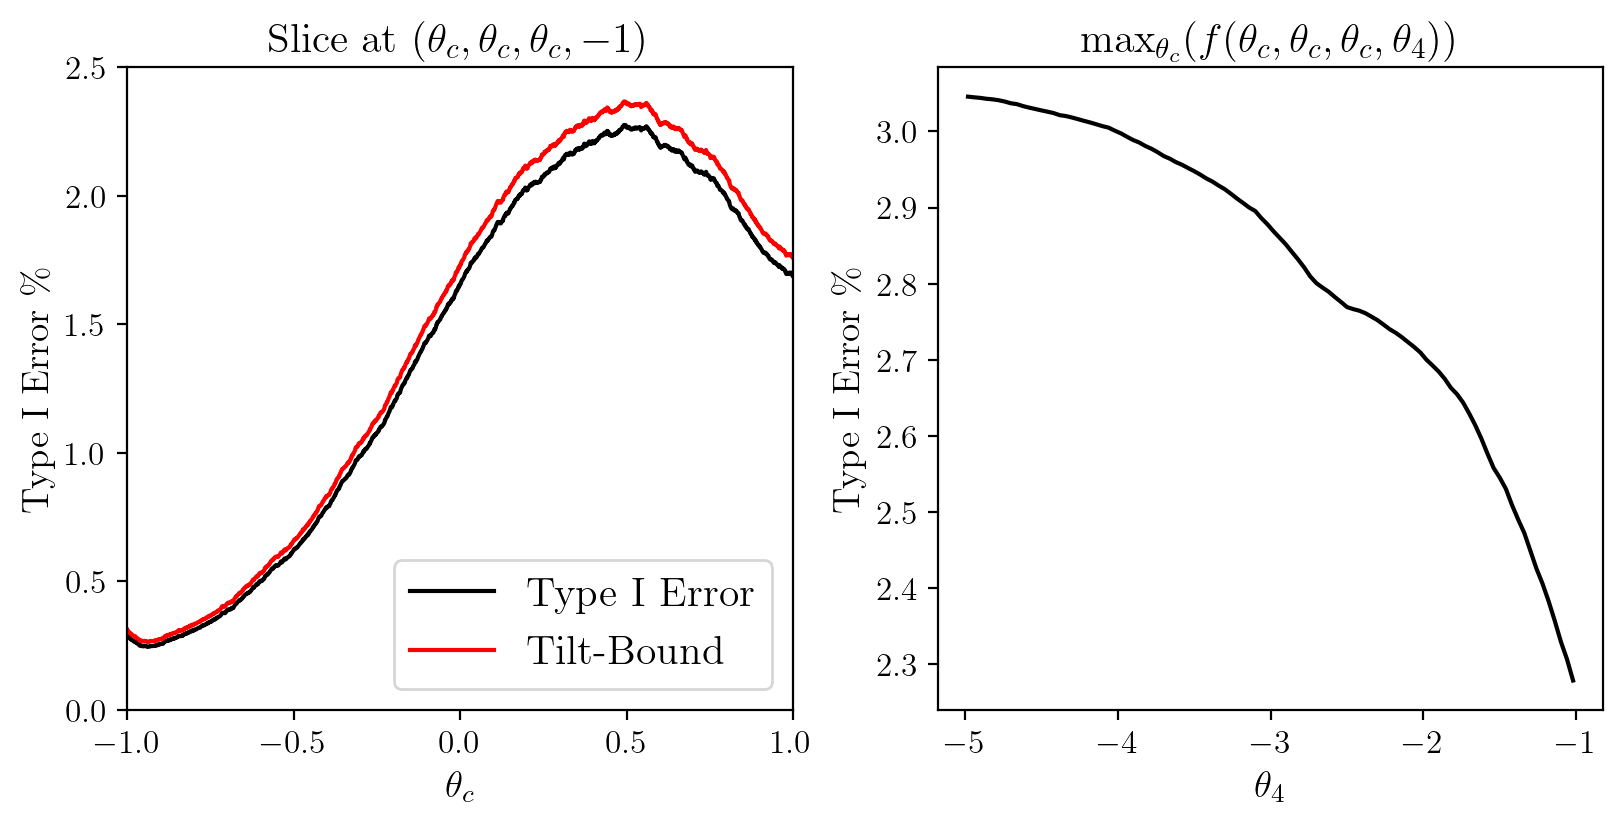

In [84]:
worst_tie = rej_dfortho["tie_est"].values.reshape((100, 20)).max(axis=1)
plt.figure(figsize=(8, 4), constrained_layout=True)
plt.subplot(1, 2, 1)
plt.plot(g1d.df["theta0"], 100 * rej_df1d["tie_est"], "k-", label="Type I Error")
# plt.plot(g.df["theta0"], 100 * rej_df["tie_cp_bound"], "b-", label="Clopper-Pearson")
plt.plot(g1d.df["theta0"], 100 * rej_df1d["tie_bound"], "r-", label="Tilt-Bound")
plt.xlim([-1, 1])
plt.ylim([0, 2.5])
plt.xlabel("$\\theta_{c}$")
plt.ylabel("Type I Error \%")
plt.legend()
plt.title("Slice at $(\\theta_{c}, \\theta_{c}, \\theta_{c}, -1)$")

plt.subplot(1, 2, 2)
plt.plot(gortho.df["theta3"].values.reshape((100, 20))[:, 0], 100 * worst_tie, "k-")
plt.xlabel(r"$\theta_{4}$")
plt.ylabel(r"Type I Error \%")
plt.title(r"$\max_{\theta_c}(f(\theta_c, \theta_c, \theta_c, \theta_4))$")
plt.savefig("lewis_1d_combined.pdf", bbox_inches="tight")
plt.show()

## Far into the distance

In [13]:
g = ip.cartesian_grid([-1, -5], [1, -1], n=[20, 100])
g = ip.cartesian_grid([-1, -500], [1, -100], n=[20, 10])
g.df["theta3"] = g.df["theta1"]
g.df["theta1"] = g.df["theta0"]
g.df["theta2"] = g.df["theta0"]
g.df["radii3"] = g.df["radii1"]
g.df["radii0"] = 0
g.df["radii1"] = 0
g.df["radii2"] = 0
g.df["null_truth0"] = True
g.df["null_truth1"] = True
g.df["null_truth2"] = True
with stub.run():
    rej_df = cloud_validate(g, K=2**17, params=params)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-BNP9LBl9pCfP4lhp9W7rrc

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

52.571306467056274


✓ App completed.

In [19]:
rej_df["tie_est"].values.reshape((10, 20)).max(axis=1)

array([0.03096771, 0.03096771, 0.03096771, 0.03096771, 0.03096771, 0.03096771, 0.03096771,
       0.03096771, 0.03096771, 0.03096771])

## [-5, 5] with $\theta_4 = -1$

In [ ]:
g = ip.cartesian_grid([-5], [5], n=[500])
with stub.run():
    rej_df = cloud_validate(g, 2**17, params)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-vRnRYqd6munKsjuh8LlqDF

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

66.54020595550537


✓ App completed.

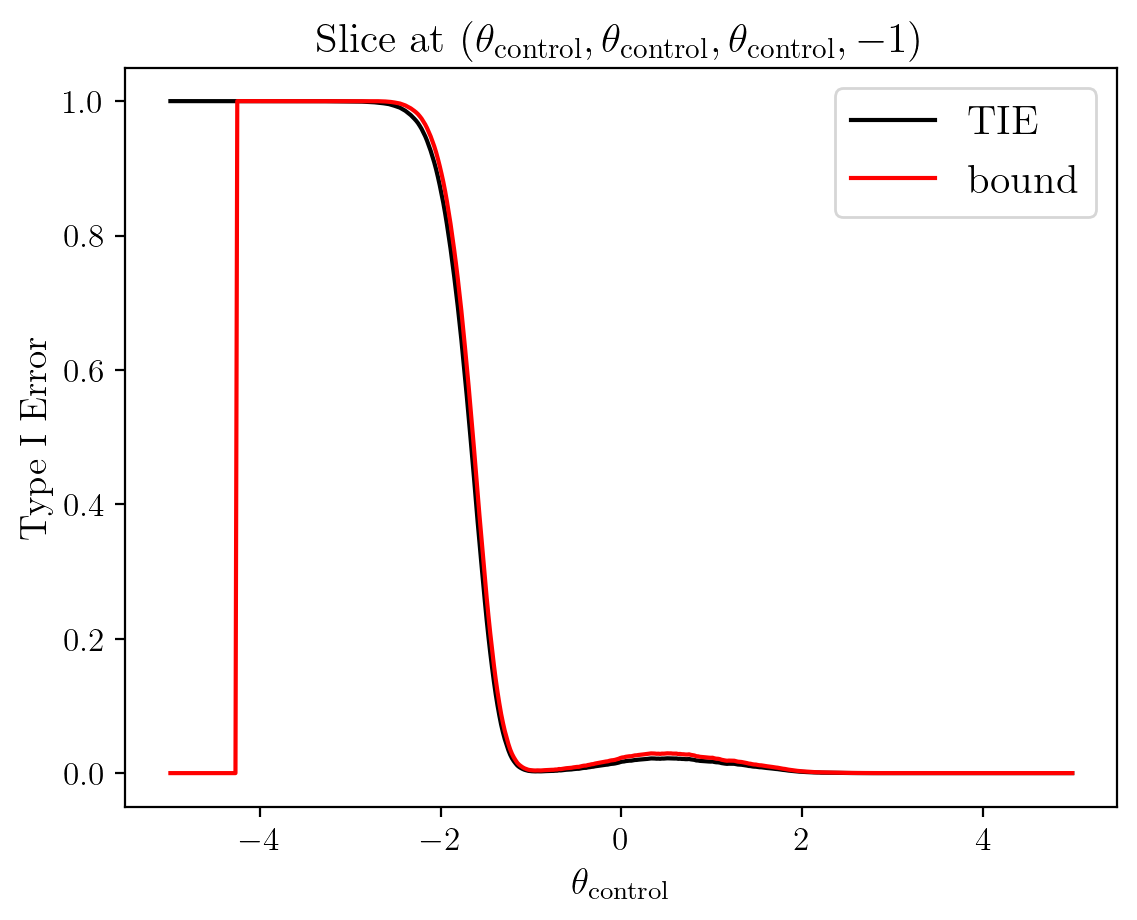

In [ ]:
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.show()

## [-1, 1] with $\theta_4 = -5$

In [ ]:
g = ip.cartesian_grid([-3], [1], n=[1000])
params5 = params.copy()
params5["bad_arm"] = -5.0
with stub.run():
    rej_df = cloud_validate(g, 2**20, params5)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-iEgcd55YX7g2djZSCJhW6L

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

413.08967757225037


✓ App completed.

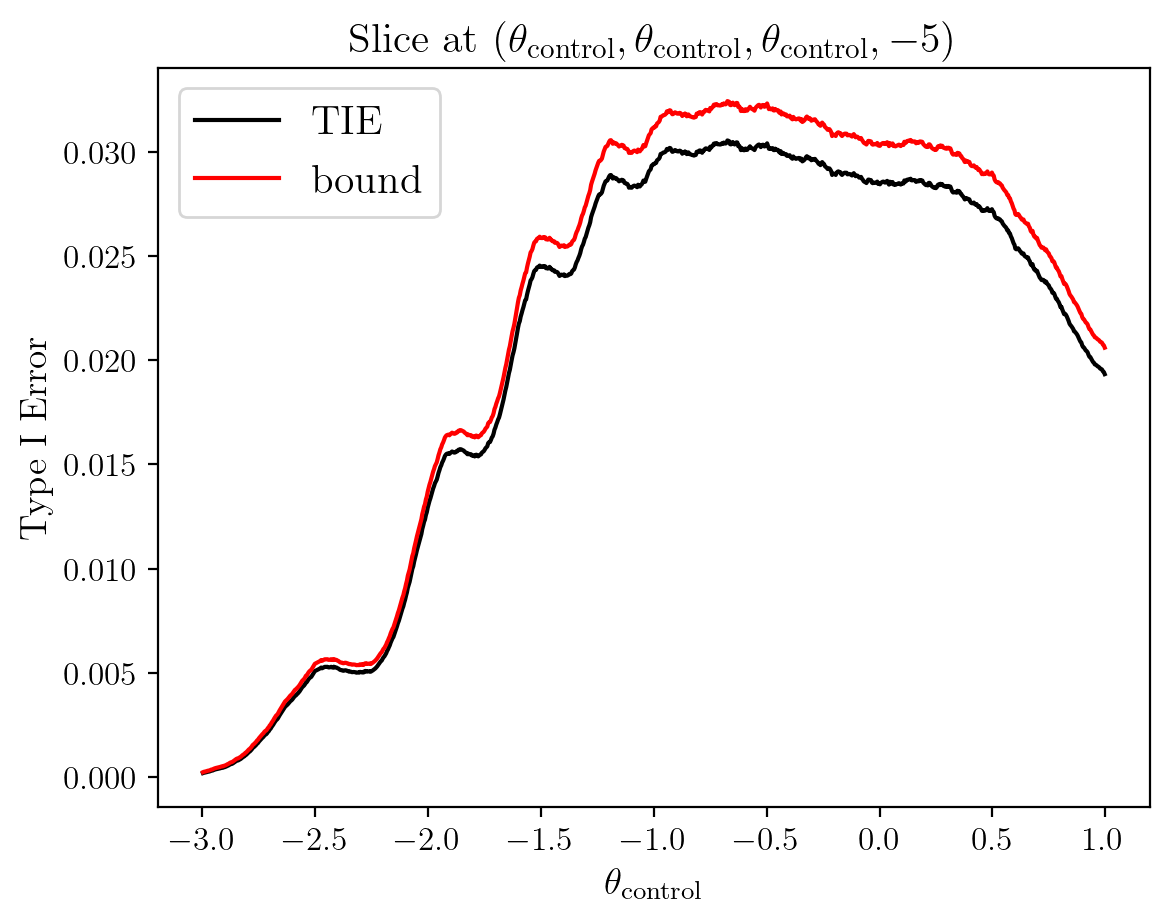

In [ ]:
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -5)$"
)
plt.show()

## Testing with AWS Batch instead of Modal.

In [ ]:
import jax

name = "1d_slice"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
    "bad_arm": -1.0,
}

In [ ]:
import confirm
import confirm.cloud.awsbatch as awsbatch
import boto3
import pickle


@awsbatch.include_package(confirm)
def job():
    from confirm.lewislib import lewis

    class Model1D:
        def __init__(self, seed, max_K, **kwargs):
            self.model = lewis.Lewis45Model(
                seed, max_K, **{k: v for k, v in kwargs.items() if k != "bad_arm"}
            )
            self.bad_arm = kwargs["bad_arm"]
            self.family = "binomial"
            self.family_params = {"n": int(self.model.lewis45.unifs_shape()[0])}

        def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
            control = theta[:, 0]
            theta = np.stack(
                (control, control, control, np.full_like(control, self.bad_arm)), axis=1
            )
            null_truth = np.full((theta.shape[0], 3), True)
            out = self.model.sim_batch(begin_sim, end_sim, theta, null_truth)
            return out

    import confirm.imprint as ip

    g = ip.cartesian_grid([-1], [1], n=[500])
    K = 2**17

    start = time.time()
    print("starting")
    rej_df = ip.validate(
        Model1D,
        g,
        lam=0.06253,
        K=K,
        tile_batch_size=256,
        model_kwargs=params,
    )
    print(time.time() - start)
    boto3.resource("s3").Object("imprint-dump", "result.pkl").put(
        Body=pickle.dumps(rej_df)
    )

In [ ]:
awsbatch.local_test(job)

Loading job from S3


Traceback (most recent call last):
  File "/main.py", line 26, in <module>
    print(main())
  File "/main.py", line 16, in main
    f = cloudpickle.loads(data)
  File "/usr/local/lib/python3.10/dist-packages/jax/__init__.py", line 35, in <module>
    from jax import config as _config_module
  File "/usr/local/lib/python3.10/dist-packages/jax/config.py", line 17, in <module>
    from jax._src.config import config  # noqa: F401
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/config.py", line 27, in <module>
    from jax._src import lib
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 85, in <module>
    cpu_feature_guard.check_cpu_features()
RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.


In [ ]:
response, bucket, filename = awsbatch.remote_run(job, cpus=4, memory=2**15, gpu=True)

In [ ]:
boto3.resource("s3").Bucket("imprint-dump").download_file("result.pkl", "result.pkl")
g = ip.cartesian_grid([-1], [1], n=[500])
with open("result.pkl", "rb") as f:
    rej_df = pickle.load(f)

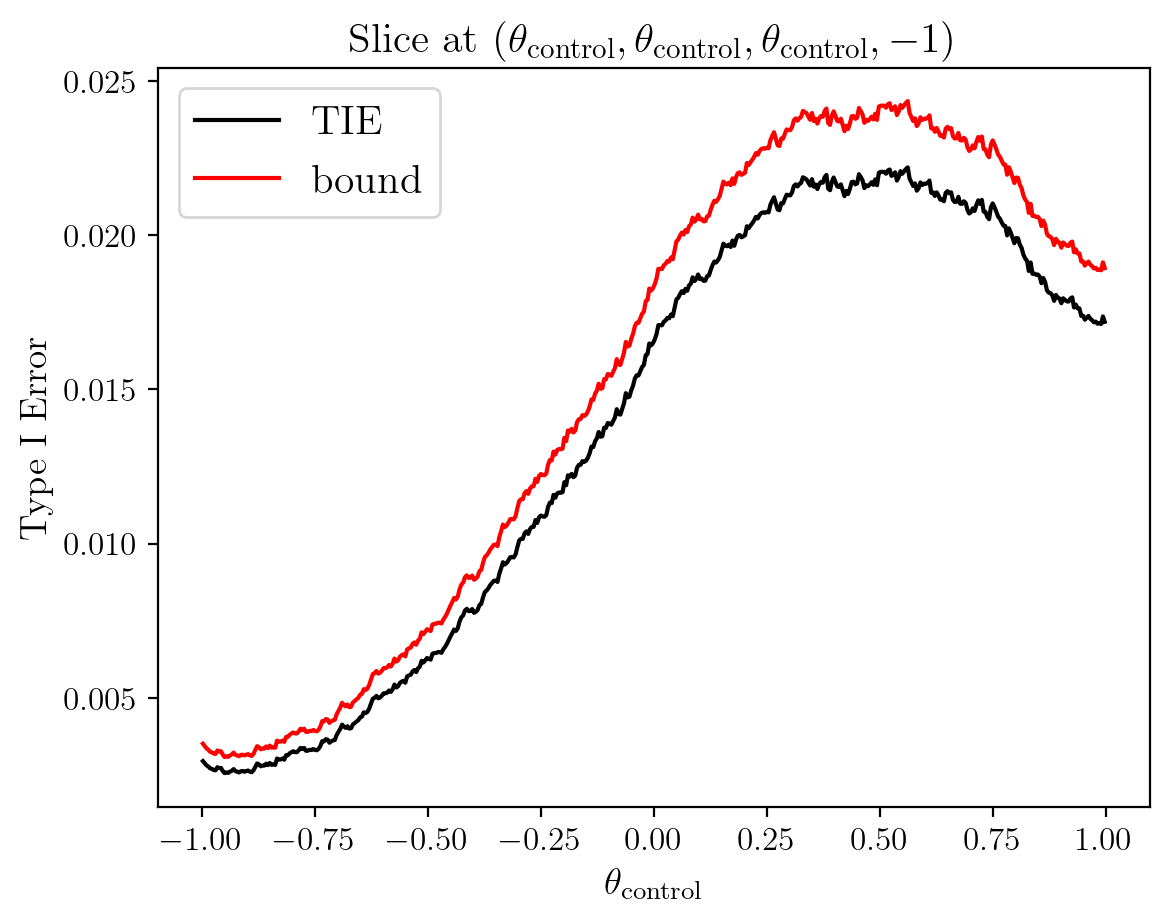

In [ ]:
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.show()